In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytz
from datetime import datetime

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# load the EVChargingStationUsage.csv into dataframe

df_main = pd.read_csv('/kaggle/input/ev-charging-station-usage-of-california-city/EVChargingStationUsage.csv')

/tmp/ipykernel_121/2094900238.py:3: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_main = pd.read_csv('/kaggle/input/ev-charging-station-usage-of-california-city/EVChargingStationUsage.csv')


In [3]:
df_main.columns

Index(['Station Name', 'MAC Address', 'Org Name', 'Start Date',
       'Start Time Zone', 'End Date', 'End Time Zone',
       'Transaction Date (Pacific Time)', 'Total Duration (hh:mm:ss)',
       'Charging Time (hh:mm:ss)', 'Energy (kWh)', 'GHG Savings (kg)',
       'Gasoline Savings (gallons)', 'Port Type', 'Port Number', 'Plug Type',
       'EVSE ID', 'Address 1', 'City', 'State/Province', 'Postal Code',
       'Country', 'Latitude', 'Longitude', 'Currency', 'Fee', 'Ended By',
       'Plug In Event Id', 'Driver Postal Code', 'User ID', 'County',
       'System S/N', 'Model Number'],
      dtype='object')

In [4]:
df_processed = df_main[['Station Name', 'Start Date', 'Start Time Zone', 'Total Duration (hh:mm:ss)', 'Charging Time (hh:mm:ss)', 'Plug Type', 'Port Type']]

df_processed['Station Name'] = df_processed['Station Name'].str.replace(' ', '')

/tmp/ipykernel_121/1180463022.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['Station Name'] = df_processed['Station Name'].str.replace(' ', '')


In [5]:
del df_main

In [6]:
# Convert the 'Start Date' column to datetime format and into common Time Xone of UTC

def convert_to_utc(row):
    try:
        dt = datetime.strptime(row['Start Date'], "%m/%d/%Y %H:%M")
    except ValueError:
        dt = datetime.strptime(row['Start Date'], "%m-%d-%Y %H:%M")

    tz = (
        pytz.timezone('America/Los_Angeles')
        if row['Start Time Zone'] in ('PDT', 'PST')
        else pytz.timezone('UTC')
    )

    return tz.localize(dt).astimezone(pytz.utc)

# Apply the conversion function and create a new column 'datetime_utc'
df_processed['Start Date'] = df_processed.apply(convert_to_utc, axis=1)

# Drop the 'Start Time Zone' column
df_processed.drop(columns=['Start Time Zone'], inplace=True)

In [7]:
df_processed['Start Month'] = df_processed['Start Date'].dt.month

df_processed['Day of Week'] = df_processed['Start Date'].dt.day_name()

df_processed['Minutes Passed From The Day'] = df_processed['Start Date'].dt.hour * 60 + df_processed['Start Date'].dt.minute

df_processed['Waiting Time'] = df_processed['Total Duration (hh:mm:ss)'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1])) - df_processed['Charging Time (hh:mm:ss)'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))

df_processed = df_processed[df_processed['Waiting Time'] >= 0]

In [8]:
# Remove row in which Plug Type is not J1772
df_processed = df_processed[df_processed['Plug Type'] == 'J1772']

df_processed.drop(columns=['Start Date', 'Total Duration (hh:mm:ss)', 'Charging Time (hh:mm:ss)', 'Plug Type', 'Port Type'], inplace=True)

In [9]:
# Doing labelling for each station

df_processed['Station Name'] = df_processed['Station Name'].astype('category').cat.codes

In [10]:
# Doing one hot encoding month

df_processed = pd.concat([df_processed, pd.get_dummies(df_processed['Start Month'], prefix='Month')], axis=1)

df_processed.drop(columns=['Start Month'], inplace=True)

In [11]:
# Doing one hot encoding day of week

df_processed = pd.concat([df_processed, pd.get_dummies(df_processed['Day of Week'], prefix='')], axis=1)

df_processed.drop(columns=['Day of Week'], inplace=True)

In [12]:
#If minutes passed from the day is greater than or equal to 301 and less than or equal to 720 then assign 1, if greater than or equal to 721 and less than or equal to 1080 then assign 2, otherwise assign 3

df_processed['Category of Start Time'] = df_processed['Minutes Passed From The Day'].apply(lambda x: 1 if x >= 301 and x <= 720 else 2 if x >= 721 and x <= 1080 else 3)

df_processed.drop(columns=['Minutes Passed From The Day'], inplace=True)

# Perform one-hot encoding
df_processed['Morning'] = df_processed['Category of Start Time'].apply(lambda x: 1 if x == 1 else 0)
df_processed['Mid Time'] = df_processed['Category of Start Time'].apply(lambda x: 1 if x == 2 else 0)
df_processed['Night'] = df_processed['Category of Start Time'].apply(lambda x: 1 if x == 3 else 0)

# Drop the original column if needed
df_processed = df_processed.drop('Category of Start Time', axis=1)

<Axes: xlabel='Waiting Time'>

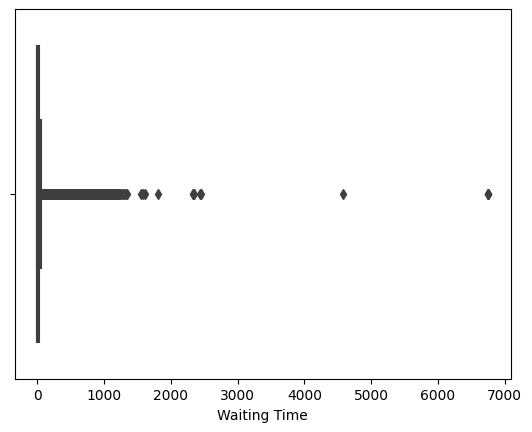

In [13]:
# Plot the box plot of waiting time

sns.boxplot(x=df_processed['Waiting Time'])

In [14]:
# Remove the rows which are outlier in Waiting Time column which is lesser than Q1 - 1.5 * IQR or greater than Q3 + 1.5 * IQR 

Q1 = df_processed['Waiting Time'].quantile(0.25)
Q3 = df_processed['Waiting Time'].quantile(0.75)
IQR = Q3 - Q1

df_processed = df_processed[(df_processed['Waiting Time'] >= Q1 - 1.5 * IQR) & (df_processed['Waiting Time'] <= Q3 + 1.5 * IQR)]    

In [15]:
# Define column Waiting Time Bucket, assign 0 if Waiting Time is less than 10 minutes, 1 if Waiting Time is less than 20 minutes, and so on

df_processed['Waiting Time Bucket'] = (df_processed['Waiting Time']/10).astype(int)

df_processed.drop(columns=['Waiting Time'], inplace=True)

In [16]:
df_processed.head()

,Station Name,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,...,_Monday,_Saturday,_Sunday,_Thursday,_Tuesday,_Wednesday,Morning,Mid Time,Night,Waiting Time Bucket
1,11,False,False,False,False,False,False,True,False,False,...,False,True,False,False,False,False,1,0,0,0
2,11,False,False,False,False,False,False,True,False,False,...,False,True,False,False,False,False,0,1,0,0
3,11,False,False,False,False,False,False,True,False,False,...,False,True,False,False,False,False,0,0,1,0
4,11,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,0,0,1,2
7,11,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,0,0,1,0


In [17]:
# Now set X as column apart from waiting time and Y as waiting time

X = df_processed.drop(columns=['Waiting Time Bucket']).values
Y = df_processed['Waiting Time Bucket'].values

In [18]:
# Split the data into training and testing set

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=101)

print(X_train.shape, Y_train.shape)

(176990, 23) (176990,)


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [20]:
# Perform standard scaling on X_train and X_test

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

Epoch 1/1000
5531/5531 [==============================] - 37s 5ms/step - loss: 0.8687 - accuracy: 0.7750 - val_loss: 0.8571 - val_accuracy: 0.7766
Epoch 2/1000
5531/5531 [==============================] - 26s 5ms/step - loss: 0.8613 - accuracy: 0.7750 - val_loss: 0.8552 - val_accuracy: 0.7766
Epoch 3/1000
5531/5531 [==============================] - 26s 5ms/step - loss: 0.8599 - accuracy: 0.7750 - val_loss: 0.8548 - val_accuracy: 0.7766
Epoch 4/1000
5531/5531 [==============================] - 25s 5ms/step - loss: 0.8593 - accuracy: 0.7750 - val_loss: 0.8536 - val_accuracy: 0.7766
Epoch 5/1000
5531/5531 [==============================] - 26s 5ms/step - loss: 0.8589 - accuracy: 0.7750 - val_loss: 0.8531 - val_accuracy: 0.7766
Epoch 6/1000
5531/5531 [==============================] - 26s 5ms/step - loss: 0.8586 - accuracy: 0.7750 - val_loss: 0.8533 - val_accuracy: 0.7766
Epoch 7/1000
5531/5531 [==============================] - 26s 5ms/step - loss: 0.8583 - accuracy: 0.7750 - val_loss: 0

<Axes: >

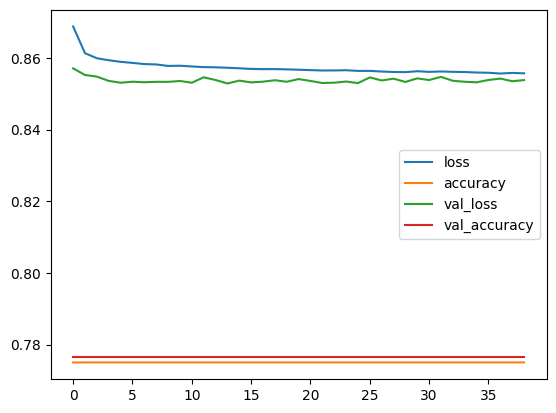

In [21]:
# Create a neural network model

model = Sequential()

model.add(Dense(256, activation='relu'))

model.add(Dense(128, activation='relu'))

model.add(Dense(64, activation='relu'))

model.add(Dense(32, activation='relu'))

model.add(Dense(16, activation='relu'))

model.add(Dense(8, activation='relu'))

model.add(Dense(6, activation='linear'))

model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Create an early stopping callback

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

# Train the model

model.fit(x=X_train, y=Y_train, epochs=1000, validation_data=(X_test, Y_test), callbacks=[early_stop])

# Plot the loss

losses = pd.DataFrame(model.history.history)

losses.plot()

In [22]:
# Make predictions
predictions = np.argmax(model.predict(X_test), axis=-1)

# Print the classification report
print('Classification Report is : ')
print(classification_report(Y_test, predictions))

# Print the confusion matrix
print('Confusion Matrix is : ')
print(confusion_matrix(Y_test, predictions))

# Print the train and test accuracy
train_accuracy = model.evaluate(X_train, Y_train, verbose=0)[1]
test_accuracy = model.evaluate(X_test, Y_test, verbose=0)[1]

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

1383/1383 [==============================] - 2s 2ms/step
Classification Report is : 
              precision    recall  f1-score   support

           0       0.78      1.00      0.87     34362
           1       0.00      0.00      0.00      3079
           2       0.00      0.00      0.00      2821
           3       0.00      0.00      0.00      1953
           4       0.00      0.00      0.00      1401
           5       0.00      0.00      0.00       632

    accuracy                           0.78     44248
   macro avg       0.13      0.17      0.15     44248
weighted avg       0.60      0.78      0.68     44248

Confusion Matrix is : 
[[34362     0     0     0     0     0]
 [ 3079     0     0     0     0     0]
 [ 2821     0     0     0     0     0]
 [ 1953     0     0     0     0     0]
 [ 1401     0     0     0     0     0]
 [  632     0     0     0     0     0]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 0.7750
Test Accuracy: 0.7766


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               6144      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 dense_6 (Dense)             (None, 6)                 5